# Competencia: Santander Customer Satisfaction

Desde los cargos de atención al cliente, hasta los cargos directivos la satisfacción del cliente es una métrica principal del éxito. Los clientes insatisfechos no permanecen por mucho tiempo; mas aún, los clientes insatisfechos no proclaman su insatisfacción antes de irse.

El Banco Santander le esta solciitando a la comunidad de Kaggle que le ayude a identificar a los clientes insatisfechos en una etapa temprana de la relación comercial. Hacerlo le permitirá a Santander tomar medidas preventivas para mejorar la satisfacción de sus clientes antes de que sea demasiado tarde.

En esta competencia usted trabajrá con cientes de características anonimizadas para predecir si un cliente está o no satisfecho con su experiencia bancaria.

## Grupo de trabajo

- John Franklin Gonzalez Gamboa - 201725981
- Jorge Eduardo Rodriguez Cardozo - 200711501
- German Augusto Carvajal Murcia - 201313516

## Acceso a la base de datos

Se ejecuta el siguiente comando dentro un la consola/terminal del equipo para acceder a la base de datos del proyecto:

- Pre: La API de Kaggle se encuentra instalada y configurada. Se han aceptado los terminos y condiciones del acceso a la base de datos de la competencia

- Post: La base de datos es descargada a la ubicación especificada

`kaggle competitions download -c santander-customer-satisfaction --path .../Santander`

## Databases loading

Una vez descargados localmente los archivos de la competencia, la base de datos de entrenamiento se carga a la memoria para inciar el proceso de limpieza.

In [1]:
import os
os.chdir(os.getcwd()+'/Santander')

In [2]:
import numpy as np
import pandas as pd
Data_train = pd.read_csv('Data_train.csv')

In [3]:
Data_train.shape

(67932, 316)

## IDENTIFICACIÓN DE OUTLIERS

La base de datos disponible para la identificación de los outliers tiene un total de 75480 registros y 315 caracteristicas individuales adicionales a la variable dependiente del modelo. La sabana de registros corresponde a un corte transversal de los clientes del banco.

El proceso de identificación de los outliers, tal y como se realizó para la identificación de los missing values será sustentado en el desarrollo realizado por Lode Nachtergaele AKA: [cast42](https://www.kaggle.com/cast42) (2015)

De acuerdo con lo mencionado por casr42, la variable 4 (num_var 4) corresponde al número de productos que tiene cada cliente por lo que se esperaría que a mayor número de productos, la satisfacción de ese cliente con el banco sea mayor. a continuación se apreciará el histograma de frecuencia el cual discretizará por la variable TARGET a la variable 4.

In [18]:
import sys
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import datetime
import seaborn as sns

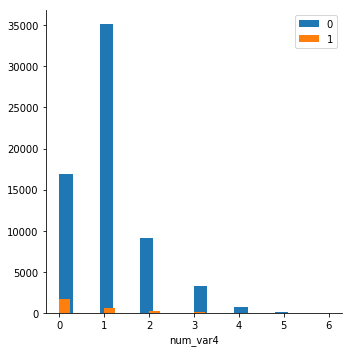

In [19]:
g = sns.FacetGrid(Data_train, hue="TARGET", size=5).map(plt.hist, "num_var4", bins=20)
plt.legend()
plt.show()

Tal y como se penso, las personas que menos productos tienen con la empresa son las más propensas a estar insatisfechas con el banco que las que más productos tienen (se observa que ninguna persona con 5 productos esta insatisfecha con el banco). 

Un gráfico de Boxplot para 2 de las variables se presenta acontinuación:

/Users/jfrank/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:57: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  return getattr(obj, method)(*args, **kwds)


array([<matplotlib.axes._subplots.AxesSubplot object at 0x1108a4470>,
       <matplotlib.axes._subplots.AxesSubplot object at 0x110a91d30>], dtype=object)

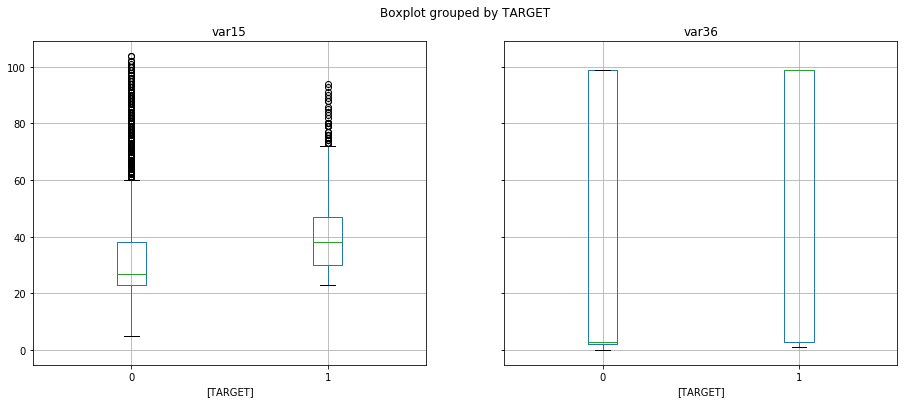

In [20]:
Data_train[['var15','var36','TARGET']].boxplot(by="TARGET", figsize=(15, 6))

Como se puede apreciar, la variable 36 presenta una distribución atípica de los datos, pero para realizar este análisis para las 316 variables consideradas es muy complicado, uno porque no se conoce que es cada variable, así que determinar si un valor es o no atípico sería muy complicado, a demás no se sabe cuál es la relación entre las variables, por lo mismo que se explico anteriormente.

Por tanto mediante la metodología LOF (Local Outlier Factor) se tratará de identificar los datos fuera del comportamiento normal de las variables.

# LOCAL OUTLIER FACTOR

Mediante el paquete llamado LocalOutlierFactor de Sklearn fue entrenado un modelo con la finalidad de identificar la desviación local de la densidad de las variables con respecto a sus vecinos. el número de registros que se encontrasen por fuera de un rango considerando las vaecindades son los registros que serán eliminados de la base de datos. Para este caso en particular, el número de vecinos determinado para la base de datos es de 30; por no conocer las variables con las cuales se están trabajando, el algoritmo seleccionado será "auto", este decidirá el algoritmo más apropiado basándose en los valores pasados.

In [4]:
from sklearn.neighbors import LocalOutlierFactor
h = LocalOutlierFactor(n_neighbors=30, algorithm='auto', metric='l1',n_jobs=-1)

In [6]:
h.fit(Data_train)

LocalOutlierFactor(algorithm='auto', contamination=0.1, leaf_size=30,
          metric='l1', metric_params=None, n_jobs=-1, n_neighbors=30, p=2)

In [7]:
scores=pd.DataFrame(h.negative_outlier_factor_*-1)

In [8]:
scores.quantile(np.linspace(0.05, 1, 38,0))

,0
0.050,0.975352
0.075,0.979361
0.100,0.982672
0.125,0.985532
0.150,0.988231
0.175,0.990892
0.200,0.993279
0.225,0.995707
0.250,0.998366
0.275,1.000000


Threshold al 90%

Luego de entrenar el modelo, se obtuvo que con un valor inferior a 2.994199 se conservará el 90% de los datos, por tanto, los registros por encima de este score serán retirados de la base de datos.

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x10a258cf8>]], dtype=object)

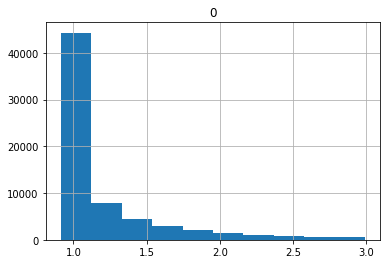

In [17]:
scores[scores[0]<2.994199].hist()

Con lo anterior se tiene que 7548 registros están por encima del valor determinado anteriormente. Luego de retirar estos valores se tiene finalmente una base de datos con 67932 registros y 316 variables.

In [10]:
sum(scores[0]>2.994199)

1564

In [91]:
Data_train=Data_train[scores[0]<2.994199]

Exportando la base de datos sin outliers

In [92]:
Data_train.to_csv('Data_train.csv', index=False)